In [1]:
!pip install monai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 102.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 74.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [2]:
import os
import nibabel as nib
import numpy as np
import torch
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, jaccard_score
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, Orientationd,
    ResizeWithPadOrCropd, NormalizeIntensityd, ToTensord
)
from monai.data import Dataset as MonaiDataset
from monai.networks.nets import UNet
from monai.losses import DiceCELoss
from monai.metrics import DiceMetric
from monai.inferers import sliding_window_inference
import matplotlib.pyplot as plt

<frozen importlib._bootstrap_external>:1241: FutureWarning: The cuda.cudart module is deprecated and will be removed in a future release, please switch to use the cuda.bindings.runtime module instead.
2025-07-30 09:01:07.129697: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753866067.324777      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753866067.380421      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
image_dir = "/kaggle/input/costa-adam/imagesTr"
label_dir = "/kaggle/input/costa-adam/labelsTr"
test_dir  = "/kaggle/input/costa-adam/imagesTs"
label_test_dir = "/kaggle/input/costa-adam/labelsTs"

image_paths = []
label_paths = []

for root, _, files in os.walk(image_dir):
    for file in files:
        if file.endswith(".nii") or file.endswith(".nii.gz"):
            image_paths.append(os.path.join(root, file))

for root, _, files in os.walk(label_dir):
    for file in files:
        if file.endswith(".nii") or file.endswith(".nii.gz"):
            label_paths.append(os.path.join(root, file))

image_paths.sort()
label_paths.sort()

print(f"Jumlah file image: {len(image_paths)}")
print(f"Jumlah file label: {len(label_paths)}")

Jumlah file image: 294
Jumlah file label: 294


In [4]:
test_paths = sorted([
    os.path.join(test_dir, f) for f in os.listdir(test_dir)
    if f.endswith(".nii") or f.endswith(".nii.gz")
])
label_test_paths = sorted([
    os.path.join(label_test_dir, f) for f in os.listdir(label_test_dir)
    if f.endswith(".nii") or f.endswith(".nii.gz")
])

print(f"\nJumlah data test: {len(test_paths)}")
print(f"\nJumlah data test: {len(label_test_paths)}")


Jumlah data test: 61

Jumlah data test: 61


In [5]:
input_size = (128, 128, 128)
train_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    Orientationd(keys=["image", "label"], axcodes="RAS"),
    ResizeWithPadOrCropd(keys=["image", "label"], spatial_size=input_size),
    NormalizeIntensityd(keys="image"),
    ToTensord(keys=["image", "label"])
])

In [6]:
data_dicts = [{"image": img, "label": lbl} for img, lbl in zip(image_paths, label_paths)]
train_len = int(0.8 * len(data_dicts))
val_len = len(data_dicts) - train_len
train_files, val_files = random_split(data_dicts, [train_len, val_len])

train_ds = MonaiDataset(train_files, transform=train_transforms)
val_ds = MonaiDataset(val_files, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=1)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(
    spatial_dims=3, in_channels=1, out_channels=1,
    channels=(32, 64, 128, 256, 512),
    strides=(2, 2, 2, 2), num_res_units=2
).to(device)

loss_fn = DiceCELoss(sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
best_loss, patience, trigger = float('inf'), 5, 0
train_losses = []
val_losses = []

In [8]:
for epoch in range(1000):
    model.train()
    epoch_loss = 0
    for batch in train_loader:
        x, y = batch["image"].to(device), batch["label"].to(device)
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss /= len(train_loader)
    train_losses.append(epoch_loss)

    val_loss = 0
    model.eval()
    with torch.no_grad():
        for val_batch in val_loader:
            val_x, val_y = val_batch["image"].to(device), val_batch["label"].to(device)
            val_pred = model(val_x)
            val_loss += loss_fn(val_pred, val_y).item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}")

    if val_loss < best_loss:
        best_loss = val_loss
        trigger = 0
        torch.save(model.state_dict(), "/kaggle/working/model.pt")
    else:
        trigger += 1
        if trigger >= patience:
            print("Early stopping.")
            break

Epoch 1, Train Loss: 1.6264, Val Loss: 1.5984
Epoch 2, Train Loss: 1.5861, Val Loss: 1.5793
Epoch 3, Train Loss: 1.5685, Val Loss: 1.5626
Epoch 4, Train Loss: 1.5520, Val Loss: 1.5473
Epoch 5, Train Loss: 1.5356, Val Loss: 1.5301
Epoch 6, Train Loss: 1.5187, Val Loss: 1.5138
Epoch 7, Train Loss: 1.5018, Val Loss: 1.4957
Epoch 8, Train Loss: 1.4818, Val Loss: 1.4763
Epoch 9, Train Loss: 1.4609, Val Loss: 1.4563
Epoch 10, Train Loss: 1.4391, Val Loss: 1.4343
Epoch 11, Train Loss: 1.4157, Val Loss: 1.4111
Epoch 12, Train Loss: 1.3914, Val Loss: 1.3890
Epoch 13, Train Loss: 1.3666, Val Loss: 1.3628
Epoch 14, Train Loss: 1.3408, Val Loss: 1.3392
Epoch 15, Train Loss: 1.3152, Val Loss: 1.3136
Epoch 16, Train Loss: 1.2887, Val Loss: 1.2910
Epoch 17, Train Loss: 1.2626, Val Loss: 1.2636
Epoch 18, Train Loss: 1.2355, Val Loss: 1.2384
Epoch 19, Train Loss: 1.2087, Val Loss: 1.2144
Epoch 20, Train Loss: 1.1820, Val Loss: 1.1884
Epoch 21, Train Loss: 1.1544, Val Loss: 1.1627
Epoch 22, Train Loss: 

In [9]:
model.load_state_dict(torch.load("/kaggle/working/model.pt"))
model.eval()
metrics = {"Dice": [], "IoU": [], "Accuracy": [], "Precision": [], "Recall": [], "F1": []}

with torch.no_grad():
    for batch in val_loader:
        x = batch["image"].to(device)
        y_true = batch["label"].cpu().numpy().flatten()
        y_pred = torch.sigmoid(model(x)).cpu().numpy().flatten()
        y_bin = (y_pred > 0.5).astype(np.uint8)

        metrics["Dice"].append(f1_score(y_true, y_bin))
        metrics["IoU"].append(jaccard_score(y_true, y_bin))
        metrics["Accuracy"].append(accuracy_score(y_true, y_bin))
        metrics["Precision"].append(precision_score(y_true, y_bin))
        metrics["Recall"].append(recall_score(y_true, y_bin))
        metrics["F1"].append(f1_score(y_true, y_bin))

print("\nValidation Metrics:")
for k, v in metrics.items():
    print(f"{k}: {np.mean(v):.4f}")


Validation Metrics:
Dice: 0.9019
IoU: 0.8232
Accuracy: 0.9970
Precision: 0.9022
Recall: 0.9043
F1: 0.9019


In [ ]:
test_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    Orientationd(keys=["image", "label"], axcodes="RAS"),
    ResizeWithPadOrCropd(keys=["image", "label"], spatial_size=input_size),
    NormalizeIntensityd(keys="image"),
    ToTensord(keys=["image", "label"])
])

test_dicts = [{"image": img, "label": lbl} for img, lbl in zip(test_paths, label_test_paths)]
test_ds = MonaiDataset(test_dicts, transform=test_transforms)
test_loader = DataLoader(test_ds, batch_size=1)

os.makedirs("/kaggle/working/predictions", exist_ok=True)
test_metrics = {"Dice": [], "IoU": [], "Accuracy": [], "Precision": [], "Recall": [], "F1": []}

for i, test_batch in enumerate(test_loader):
    x = test_batch["image"].to(device)
    y_true = test_batch["label"].cpu().numpy().flatten()

    with torch.no_grad():
        pred = sliding_window_inference(x, roi_size=input_size, sw_batch_size=1, predictor=model)
        pred_np = torch.sigmoid(pred).cpu().numpy()[0, 0]
        pred_bin = (pred_np > 0.5).astype(np.uint8)

    pred_nii = nib.Nifti1Image(pred_bin, affine=np.eye(4))
    nib.save(pred_nii, f"/kaggle/working/predictions/prediction_{i}.nii.gz")

    y_pred_flat = pred_bin.flatten()
    test_metrics["Dice"].append(f1_score(y_true, y_pred_flat))
    test_metrics["IoU"].append(jaccard_score(y_true, y_pred_flat))
    test_metrics["Accuracy"].append(accuracy_score(y_true, y_pred_flat))
    test_metrics["Precision"].append(precision_score(y_true, y_pred_flat))
    test_metrics["Recall"].append(recall_score(y_true, y_pred_flat))
    test_metrics["F1"].append(f1_score(y_true, y_pred_flat))

print("\nTest Metrics:")
for k, v in test_metrics.items():
    print(f"{k}: {np.mean(v):.4f}")


Test Metrics:
Dice: 0.9118
IoU: 0.8391
Accuracy: 0.9975
Precision: 0.9091
Recall: 0.9170
F1: 0.9118


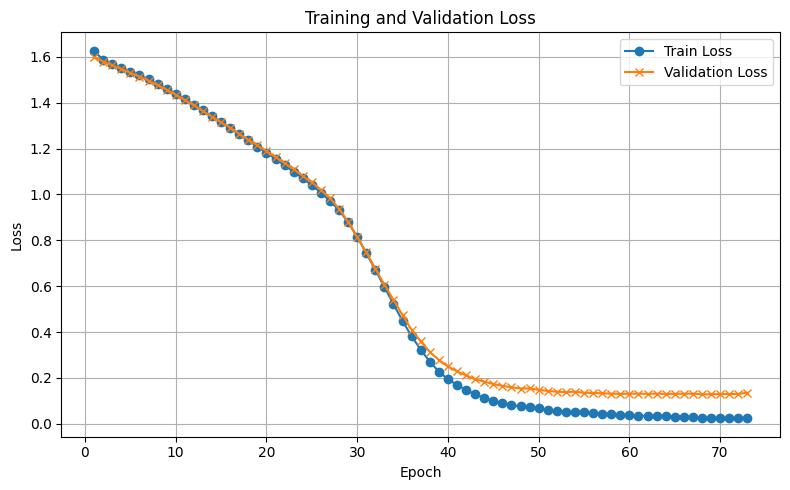

In [11]:
plt.figure(figsize=(8, 5))
epochs = range(1, len(train_losses) + 1)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

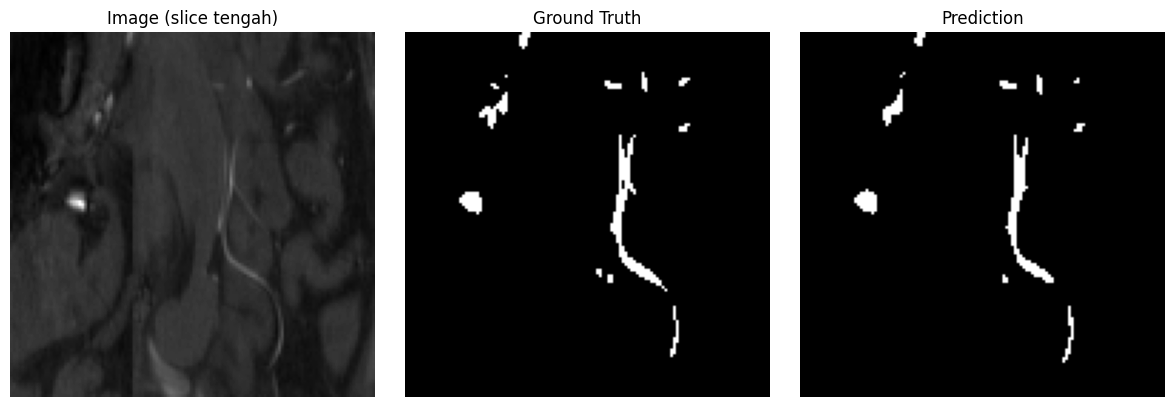

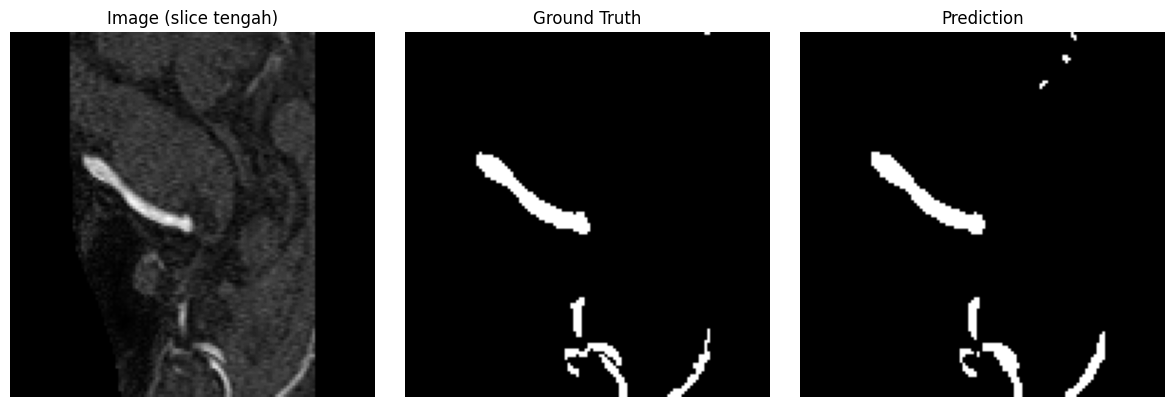

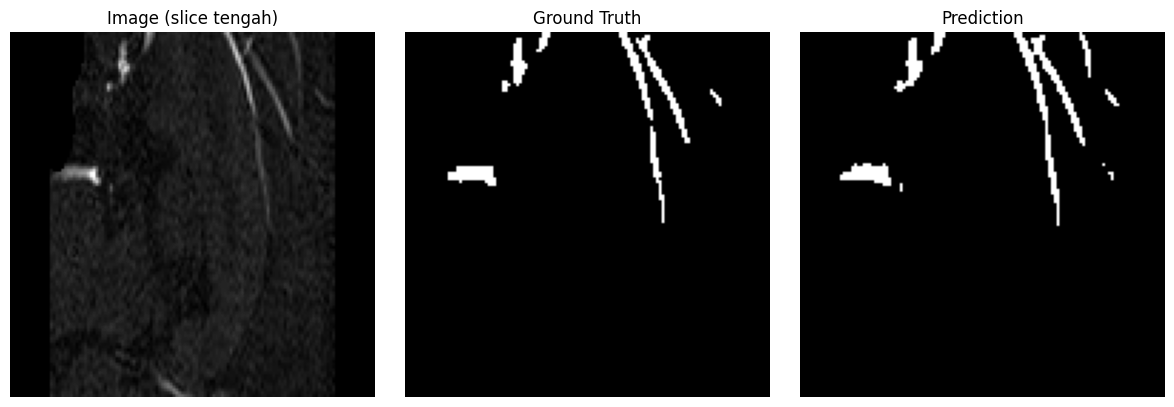

In [ ]:
import matplotlib.pyplot as plt

model.eval()
num_samples = 3

with torch.no_grad():
    for i, batch in enumerate(val_loader):
        if i >= num_samples:
            break
        image, label = batch["image"].to(device), batch["label"].to(device)

        output = model(image)
        output = torch.sigmoid(output)
        pred = output > 0.5

        for j in range(image.shape[0]):
            img_np = image[j].cpu().numpy()[0]
            label_np = label[j].cpu().numpy()[0]
            pred_np = pred[j].cpu().numpy()[0]

            mid_slice = img_np.shape[0] // 2
            img_slice = img_np[mid_slice]
            label_slice = label_np[mid_slice]
            pred_slice = pred_np[mid_slice]

            plt.figure(figsize=(12, 4))
            plt.subplot(1, 3, 1)
            plt.imshow(img_slice, cmap='gray')
            plt.title("Image (slice tengah)")
            plt.axis("off")

            plt.subplot(1, 3, 2)
            plt.imshow(label_slice, cmap='gray')
            plt.title("Ground Truth")
            plt.axis("off")

            plt.subplot(1, 3, 3)
            plt.imshow(pred_slice, cmap='gray')
            plt.title("Prediction")
            plt.axis("off")

            plt.tight_layout()
            plt.show()